# Diagnosing Patients with Viral or Bacterial Pneumonia using CNNs

What follows is an illustration of how computer vision can be used to diagnose illnesses in the healthcare setting.  Using Convolutions Neural Networks with image augmentation techniques are capable of providing accurate descriptions of patient ailments.

The algorithm is accurately able to distinguish between chest xrays of patients with three presentations: 
* normal conditions 
* viral pneumonia
* bacterial pneumonia

The accuracy level is 84.78%


The data: All data images are taken from publicly available image sets which have been pre-labeled

The images include both viral and bacterial pneumonia in addition to normal chest xrays as the baseline.
Despite several limitations including computing restrictions the algorithm developed is capable of accurately distinguishing between normal, bacterial pneumonia and viral pneumonia xrays.

As a result of the several limitations, the algorithm is not as stable as it otherwise would be however given the circumstances of a 4th generation Intel i7 and a modest 2 GB GPU the results provide significant starting point moving forward.

* The training set is made up of 5232 frontal chest xrays which split into a training and validation set.
* The test set is made up of 624 front chest xrays. 

Details of the dataset can be found throughout the body of the code.  Due to the illustrative purposes of this image set, many details are omitted including seed information as well as how image augmentation takes place although it is possible to easly Google information.  

The code has been kept as simple as possible and shows that complex code is not necessary to produce complex results.

In [1]:
# Import modules

import tensorflow as tf
import zipfile
import os
import glob
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns
import numpy as np
from skimage import exposure

print('The version of Tensorflow we are using is', tf.__version__)

The version of Tensorflow we are using is 2.0.0


In [2]:
# Locate and unzip the file with the images to desktop in folder named chest_images

local_zip_from = 'C:/Users/andre/Desktop/xray_data/ZhangLabData.zip'
local_zip_to = zipfile.ZipFile(local_zip_from, 'r')
local_zip_to.extractall('C:/Users/andre/Desktop/chest_images')
local_zip_to.close()

In [3]:
# Set the base, training and test directories

base_dir = 'C:/Users/andre/Desktop/chest_images/CellData/chest_xray/'
train_dir = os.path.join(base_dir, 'train/')
test_dir = os.path.join(base_dir, 'test/')

print(train_dir)
print(test_dir)

C:/Users/andre/Desktop/chest_images/CellData/chest_xray/train/
C:/Users/andre/Desktop/chest_images/CellData/chest_xray/test/


In [4]:
# Now we want to set the directories to our images

train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

test_normal_dir = os.path.join(test_dir, 'NORMAL')
test_pneumonia_dir = os.path.join(test_dir, 'PNEUMONIA')

In [5]:
# Discovering the total amount of each type of image but our work is not done, we stil need to determine the number
# of viral pneumonia images vs bacterial pneumonia images within the pneumonia image sets

print('We have a total of ', len(os.listdir(train_normal_dir)), 'normal chest xrays in our training set')
print('We have a total of ', len(os.listdir(train_pneumonia_dir)), 'pneumonia chest xrays in our training set')
print('We have a total of ', len(os.listdir(test_normal_dir)), 'normal chest xrays in our test set')
print('We have a total of ', len(os.listdir(test_pneumonia_dir)), 'pneumonia chest xrays in our test set')

We have a total of  1349 normal chest xrays in our training set
We have a total of  3884 pneumonia chest xrays in our training set
We have a total of  235 normal chest xrays in our test set
We have a total of  390 pneumonia chest xrays in our test set


In [6]:
# Counting the number of baceterial and viral pneumonia chest xrays in our training and testing sets

TrainBacterialCounter = len(glob.glob1(train_pneumonia_dir,"bacter*"))
print('The number of bacterial pneumonia chest xrays in our training set is :',TrainBacterialCounter)
TrainViralCounter = len(glob.glob1(train_pneumonia_dir, "vir*"))
print('The number of viral pneumonia chest xrays in our training set is :',TrainViralCounter)
TestBacterialCounter = len(glob.glob1(test_pneumonia_dir,"bacter*"))
print('The number of bacterial pneumonia chest xrays in our test set is :',TestBacterialCounter)
TestViralCounter = len(glob.glob1(test_pneumonia_dir, "vir*"))
print('The number of bacterial pneumonia chest xrays in our test set is :',TestViralCounter)


The number of bacterial pneumonia chest xrays in our training set is : 2538
The number of viral pneumonia chest xrays in our training set is : 1345
The number of bacterial pneumonia chest xrays in our test set is : 242
The number of bacterial pneumonia chest xrays in our test set is : 148


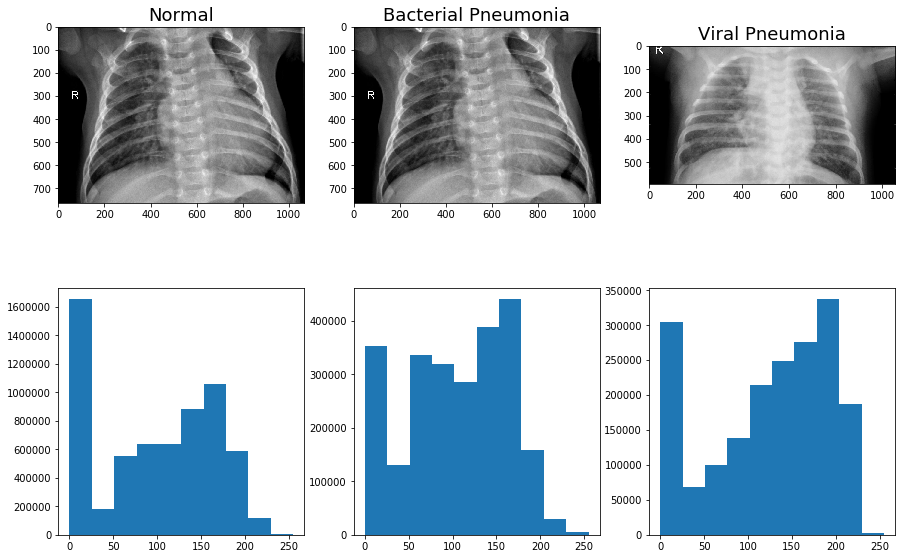

In [7]:
# Pulling samples of each kind of chest xray for cursory look

normal1 = cv2.imread('C:/Users/andre/Desktop/chest_images/CellData/chest_xray/train/NORMAL/NORMAL-66795-0001.jpeg')
bacterial1 = cv2.imread('C:/Users/andre/Desktop/chest_images/CellData/chest_xray/train/PNEUMONIA/BACTERIA-7422-0001.jpeg')
viral1 = cv2.imread('C:/Users/andre/Desktop/chest_images/CellData/chest_xray/train/PNEUMONIA/VIRUS-564683-0004.jpeg')

# Show the images
fig = plt.figure(figsize=(15, 10))

# Subplot for normal chest xray
a = fig.add_subplot(2,3,1)
imgplot = plt.imshow(bacterial1)
a.set_title('Normal', fontsize = 18)

# Subplot for bacterial pneumonia xray
a = fig.add_subplot(2,3,2)
imgplot = plt.imshow(bacterial1)
a.set_title('Bacterial Pneumonia', fontsize = 18)

# Subplot for viral pneumonia xray
a = fig.add_subplot(2,3,3)
imgplot = plt.imshow(viral1)
a.set_title('Viral Pneumonia', fontsize = 18)

# Subplots for histograms
a = fig.add_subplot(2,3,4)
imgplot = plt.hist(normal1.ravel())

a=fig.add_subplot(2,3,5)
imgplot = plt.hist(bacterial1.ravel())

a=fig.add_subplot(2,3,6)
imgplot = plt.hist(viral1.ravel())


plt.show()

### Preparing the Training image set

In [8]:
Images = []
Labels = []

Normal = os.listdir('C:/Users/andre/Desktop/chest_images/CellData/chest_xray/train/NORMAL/')

# Preparing and labelling Normal xrays
for n in Normal:
    if "NORMAL" in n:
        image = cv2.imread('C:/Users/andre/Desktop/chest_images/CellData/chest_xray/train/NORMAL/' + n)
        images = Image.fromarray(image, 'RGB')
        images_Resize = images.resize((200,250))
        Images.append(np.array(images_Resize))
        Labels.append(0)
        
Virus = os.listdir('C:/Users/andre/Desktop/chest_images/CellData/chest_xray/train/PNEUMONIA/')

# Preparing and labelling Virus xrays
for v in Virus:
    if "VIRUS" in v:
        image = cv2.imread('C:/Users/andre/Desktop/chest_images/CellData/chest_xray/train/PNEUMONIA/' + v)
        images = Image.fromarray(image, 'RGB')
        images_Resize = images.resize((200,250))
        Images.append(np.array(images_Resize))
        Labels.append(1)
        
Bacteria = os.listdir('C:/Users/andre/Desktop/chest_images/CellData/chest_xray/train/PNEUMONIA/')

# Preparing and labelling Bacteria xrays
for b in Bacteria:
    if "BACTERIA" in b:
        image = cv2.imread('C:/Users/andre/Desktop/chest_images/CellData/chest_xray/train/PNEUMONIA/' + b)
        images = Image.fromarray(image, 'RGB')
        images_Resize = images.resize((200,250))
        Images.append(np.array(images_Resize))
        Labels.append(2)

In [9]:
print(len(Images))
print(len(Labels))

5232
5232


In [10]:
Training_Images = np.array(Images)
Training_Labels = np.array(Labels)

In [11]:
print(Training_Images.shape)
print(Training_Labels.shape)

(5232, 250, 200, 3)
(5232,)


In [12]:
Training_Images_Eq = exposure.equalize_hist(Training_Images)

In [13]:
print(Training_Images_Eq.shape)

(5232, 250, 200, 3)


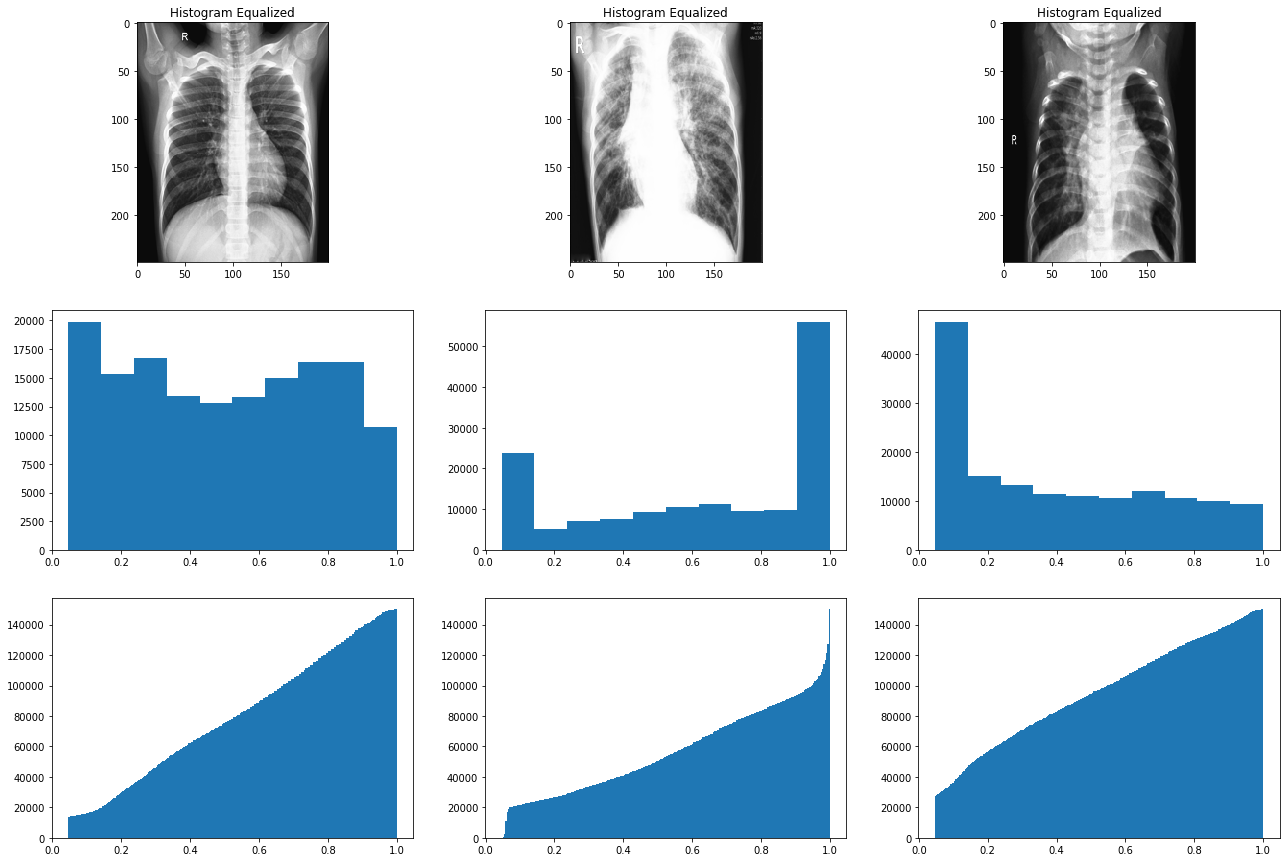

In [14]:
# Picking 3 random images to display and verify they have been augmented
fig = plt.figure(figsize=(22,15))

# Subplot for a few equalized xrays
eq1 = fig.add_subplot(3,3,1)
imgplot = plt.imshow(Training_Images_Eq[0])
eq1.set_title('Histogram Equalized')

eq2 = fig.add_subplot(3,3,2)
imgplot = plt.imshow(Training_Images_Eq[2500])
eq2.set_title('Histogram Equalized')

eq3 = fig.add_subplot(3,3,3)
imgplot = plt.imshow(Training_Images_Eq[5000])
eq3.set_title('Histogram Equalized')

# Subplots for equalized histograms of a few xrays
eq1 = fig.add_subplot(3,3,4)
imgplot = plt.hist(Training_Images_Eq[0].ravel())

eq2 = fig.add_subplot(3,3,5)
imgplot = plt.hist(Training_Images_Eq[2500].ravel())

eq3 = fig.add_subplot(3,3,6)
imgplot = plt.hist(Training_Images_Eq[5000].ravel())

# Subplots for CDFs for a few xrays
eq1 = fig.add_subplot(3,3,7)
imgplot = plt.hist(Training_Images_Eq[0].ravel(), bins=255, cumulative=True)

eq2 = fig.add_subplot(3,3,8)
imgplot = plt.hist(Training_Images_Eq[2500].ravel(), bins=255, cumulative=True)

eq3 = fig.add_subplot(3,3,9)
imgplot = plt.hist(Training_Images_Eq[5000].ravel(), bins=255, cumulative=True)

plt.show()


### Preparing the Test image set

In [15]:
Images_Test = []
Labels_Test = []

Normal = os.listdir('C:/Users/andre/Desktop/chest_images/CellData/chest_xray/test/NORMAL/')

# Preparing and labelling Normal xrays for Test set
for n in Normal:
    if "NORMAL" in n:
        image = cv2.imread('C:/Users/andre/Desktop/chest_images/CellData/chest_xray/test/NORMAL/' + n)
        images = Image.fromarray(image, 'RGB')
        images_Resize = images.resize((200,250))
        Images_Test.append(np.array(images_Resize))
        Labels_Test.append(0)
        
Virus = os.listdir('C:/Users/andre/Desktop/chest_images/CellData/chest_xray/test/PNEUMONIA/')

# Preparing and labelling Virus xrays
for v in Virus:
    if "VIRUS" in v:
        image = cv2.imread('C:/Users/andre/Desktop/chest_images/CellData/chest_xray/test/PNEUMONIA/' + v)
        images = Image.fromarray(image, 'RGB')
        images_Resize = images.resize((200,250))
        Images_Test.append(np.array(images_Resize))
        Labels_Test.append(1)
        
Bacteria = os.listdir('C:/Users/andre/Desktop/chest_images/CellData/chest_xray/test/PNEUMONIA/')

# Preparing and labelling Bacteria xrays
for b in Bacteria:
    if "BACTERIA" in b:
        image = cv2.imread('C:/Users/andre/Desktop/chest_images/CellData/chest_xray/test/PNEUMONIA/' + b)
        images = Image.fromarray(image, 'RGB')
        images_Resize = images.resize((200,250))
        Images_Test.append(np.array(images_Resize))
        Labels_Test.append(2)

In [16]:
print(len(Images_Test))
print(len(Labels_Test))

624
624


In [17]:
Testing_Images = np.array(Images_Test)
Testing_Labels = np.array(Labels_Test)

In [18]:
print(Testing_Images.shape)
print(Testing_Labels.shape)

(624, 250, 200, 3)
(624,)


In [19]:
Testing_Images_Eq = exposure.equalize_hist(Testing_Images)

In [20]:
print(Testing_Images_Eq.shape)

(624, 250, 200, 3)


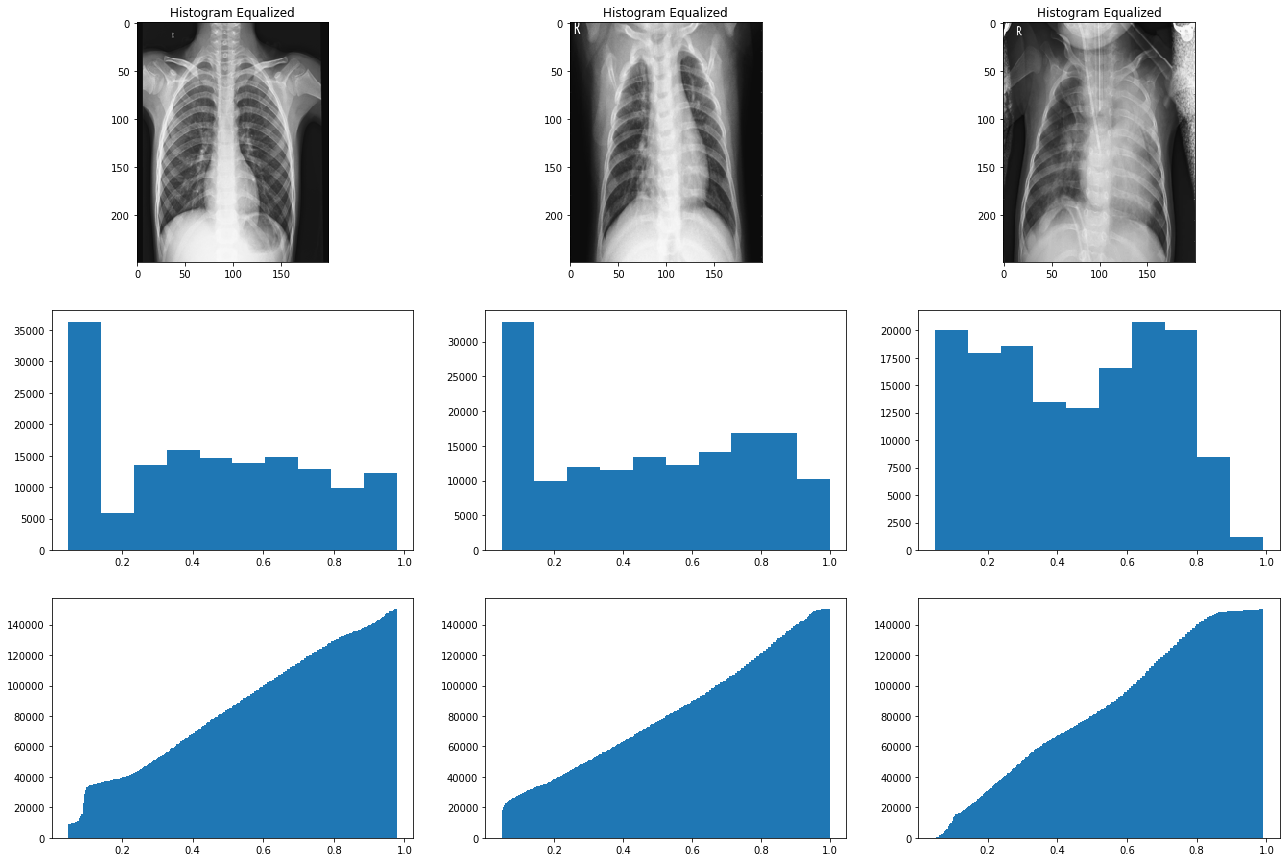

In [21]:
# Picking 3 random images to display and verify they have been augmented
figT = plt.figure(figsize=(22,15))

# Subplot for a few equalized xrays
eq1T = figT.add_subplot(3,3,1)
imgplot = plt.imshow(Testing_Images_Eq[0])
eq1T.set_title('Histogram Equalized')

eq2T = figT.add_subplot(3,3,2)
imgplot = plt.imshow(Testing_Images_Eq[300])
eq2T.set_title('Histogram Equalized')

eq3T = figT.add_subplot(3,3,3)
imgplot = plt.imshow(Testing_Images_Eq[600])
eq3T.set_title('Histogram Equalized')

# Subplots for equalized histograms of a few xrays
eq1T = figT.add_subplot(3,3,4)
imgplot = plt.hist(Testing_Images_Eq[0].ravel())

eq2T = figT.add_subplot(3,3,5)
imgplot = plt.hist(Testing_Images_Eq[300].ravel())

eq3T = figT.add_subplot(3,3,6)
imgplot = plt.hist(Testing_Images_Eq[600].ravel())

# Subplots for CDFs for a few xrays
eq1T = figT.add_subplot(3,3,7)
imgplot = plt.hist(Testing_Images_Eq[0].ravel(), bins=255, cumulative=True)

eq2T = figT.add_subplot(3,3,8)
imgplot = plt.hist(Testing_Images_Eq[300].ravel(), bins=255, cumulative=True)

eq3T = figT.add_subplot(3,3,9)
imgplot = plt.hist(Testing_Images_Eq[600].ravel(), bins=255, cumulative=True)

plt.show()


In [22]:
def show_images(image, label):
    fig = plt.figure(figsize = (15,15))
    fig.suptitle('30 Images from the dataset' ,fontsize = 15)
    for i in range(30):
        index = np.random.randint(Training_Images_Eq.shape[0])
        plt.subplot(6,5,i+1)
        plt.imshow(image[index])
        plt.xticks([]) #Scale doesn't appear
        plt.yticks([]) #Scale doesn't apper
        plt.title((label[index]))
        plt.grid(False)
    plt.show()

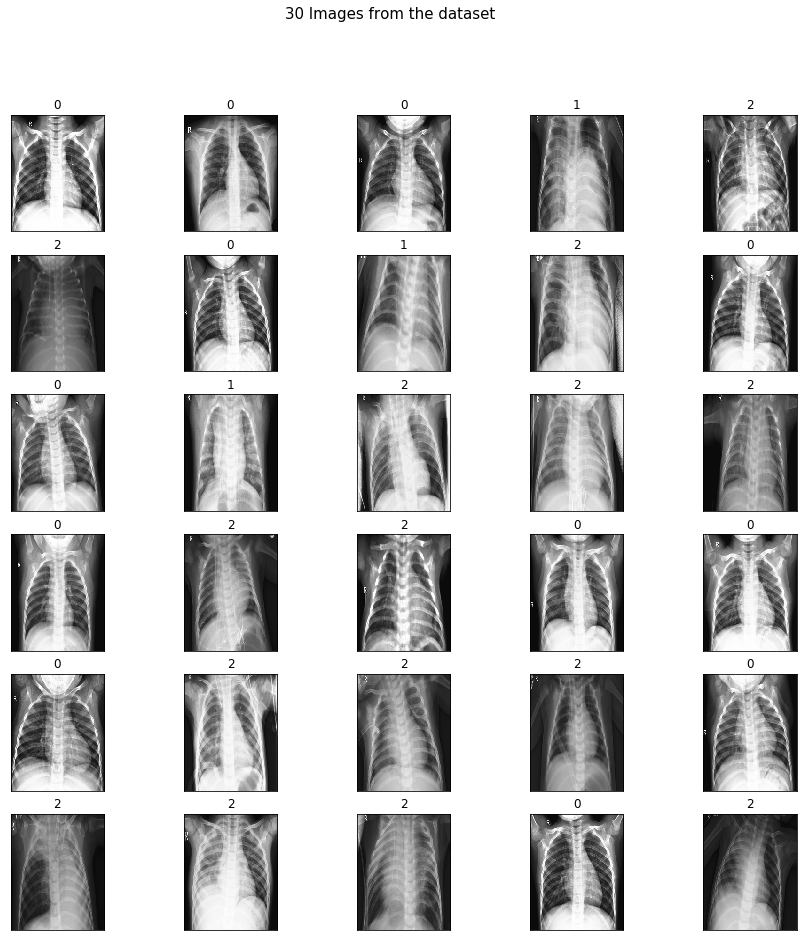

In [23]:
show_images(Training_Images_Eq, Training_Labels)

In [24]:
# Normalizing the images

#Training_Images_Eq = Training_Images_Eq/255.0
#Testing_Images_Eq = Testing_Images_Eq/255.0

### Building the model

In [43]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(Training_Images_Eq, Training_Labels, train_size = 1, shuffle = True)

In [44]:
# Build the model

import tensorflow.keras.models as Models
import tensorflow.keras.layers as Layers
import tensorflow.keras.optimizers as Optimizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=(250, 200, 3)),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'),
    tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'),
    tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'),
    tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'),
    tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'),
    tf.keras.layers.Conv2D(256, (2,2), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer = Optimizers.RMSprop(lr = 0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 249, 199, 32)      416       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 124, 99, 32)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 123, 98, 64)       8256      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 61, 49, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 60, 48, 64)        16448     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 30, 24, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 29, 23, 128)      

### Training the model

In [45]:
# Setting the hyperparameters

BATCH_SIZE = 16
EPOCHS = 10

In [46]:
# GPU does not contain enough memory
#with tf.device('/CPU:0'):
history = model.fit(Training_Images_Eq, Training_Labels, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, callbacks=None, validation_split=0.2, shuffle=True)

Train on 4185 samples, validate on 1047 samples
Epoch 1/10
4185/4185 [==============================] - 74s 18ms/sample - loss: 0.8671 - accuracy: 0.5795 - val_loss: 1.1927 - val_accuracy: 0.0783
Epoch 2/10
4185/4185 [==============================] - 73s 18ms/sample - loss: 0.6191 - accuracy: 0.7152 - val_loss: 0.6175 - val_accuracy: 0.7574
Epoch 3/10
4185/4185 [==============================] - 75s 18ms/sample - loss: 0.5399 - accuracy: 0.7527 - val_loss: 0.4976 - val_accuracy: 0.8252
Epoch 4/10
4185/4185 [==============================] - 75s 18ms/sample - loss: 0.5016 - accuracy: 0.7704 - val_loss: 0.5828 - val_accuracy: 0.7412
Epoch 5/10
4185/4185 [==============================] - 75s 18ms/sample - loss: 0.4692 - accuracy: 0.7804 - val_loss: 0.7523 - val_accuracy: 0.6046
Epoch 6/10
4185/4185 [==============================] - 75s 18ms/sample - loss: 0.4421 - accuracy: 0.7998 - val_loss: 0.9739 - val_accuracy: 0.4986
Epoch 7/10
4185/4185 [==============================] - 75s 18ms

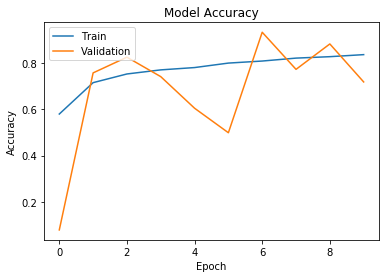

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc = "upper left")
plt.show()

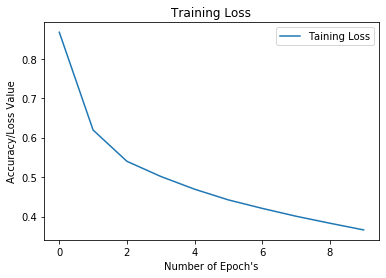

In [48]:
plt.plot(range(EPOCHS), history.history['loss'], label = 'Taining Loss')
plt.xlabel("Number of Epoch's")
plt.ylabel('Accuracy/Loss Value')
plt.title('Training Loss')
plt.legend(loc = "best")
plt.show()

# ACCURACY

In [49]:
result = model.evaluate(Testing_Images_Eq,Testing_Labels,verbose = 2)

624/1 - 4s - loss: 0.4291 - accuracy: 0.8478


In [50]:
c = list(result)
print('*********************************************************************')
print(f'     The model is able to correctly diagnose {c[1]*100:.2f}% of all xrays')
print('*********************************************************************')

*********************************************************************
     The model is able to correctly diagnose 84.78% of all xrays
*********************************************************************


In [51]:
model.save("C:/Users/andre/Desktop/Models/virus_bacteria_normal_xray_04252020.h5")

### Post test evaluation

Part of the overall post test evaluation is to check the model vs individual chest x-rays.  

Below is just one example of a patient's xray.  

It is patient 406.  
This patient is chosen at random.
As can be seen, the algorithm's diagnosis of patient 406 is that he/she has bacterial pneumonia and indeed we can see that the true label is infact bacterial pneumonia.  Additionally, we can see the level of confidence the algorithm has in making this prediction.  Green is used to provide easy visualization where the prediction by the algorithm is correct and matches the true label.  In circumstances where the algorithm is incorrect, the font would be a bright red.

There are several limitations to this project that make this more for illustrative purposes then applicable for real world cases.
First, the image set is available from public sites and as a result, there is little information available other than the true labels.  For example, how long the condition has been present in the patient is unknown.  For viral pneumonia, attempting to diagnose an xray three days into the condition vs seven days in would present dramatically different image conditions.
Second, images have been resized which loses significant information.  The original dataset has images that are 1200 x 1000, wherease the model resized the images to 250 x 200.  This is done for multiple reasons including the lack of hardware capabilities on a laptop as well as memory.  Clearly, the ability to analyze, can and should result in more accurate predictions.  Furthermore, the algorithm is truncated for the same reasons.
Third, the conditions with which the image set is compiled and labelled is assumed to have been read by at least one radiologist to confirm the labels.  The cannot be confirmed or verified.

It is for these reasons that this analysis is illustrative in nature, but it clearly demonstrates how computer vision can be used to disrupt imaging in the healthcare domain.


In [481]:
# Chest xray number

a = 406

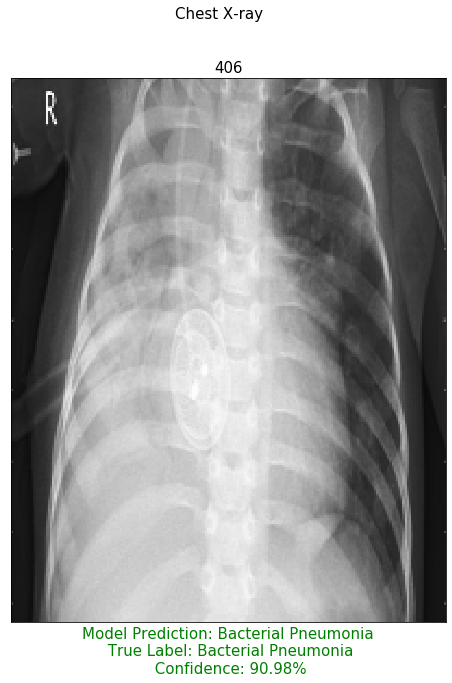

In [482]:
predictions = model.predict(Testing_Images_Eq)
predictions.shape

# Prediction by the algorithm

x = predictions[a]
l = list(x)
g = np.amax(l)
y = l.index(max(l))

if y == 0:
    y = 'Normal'
elif y == 1:
    y = 'Virus Pneumonia'
else:
    y = 'Bacterial Pneumonia'

# True label for the image

z = Testing_Labels[a]

if z == 0:
    z = 'Normal'
elif z == 1:
    z = 'Virus Pneumonia'
else:
    z = 'Bacterial Pneumonia'

i = a
plt.figure(figsize=(10,10))
plt.grid(False)
plt.suptitle('Chest X-ray', fontsize = 15)
plt.title(a, fontsize = 15)
plt.xticks([])
plt.yticks([])
plt.xlabel(f'Model Prediction: {y}\n True Label: {z}\n Confidence: {100 * (g):.2f}%', fontsize = 15, color = color)

if y == z:
    color = 'green'
else:
    color = 'red'
    
plt.imshow(Testing_Images_Eq[a])